# Community Data Model Building [A680] + [Awav] ~ [A560]
    
    In this notebook we will build the fial models using simple linear regression and multiple linear regression to regress to A560 absorbance. We use A680 and a combination of one from the following [720, 730, 750]. The helper functions used here were defined previously in notebooks where the bacterium used during the absorbance was one single strain.

In [1]:
import numpy as np
import pandas as pd
import os
import scipy

from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.gridspec as gridspec

import seaborn as sns
sns.set(style='whitegrid')

from os.path import join as pjoin
import itertools as it

%config InteractiveShell.ast_node_interactivity='all'
%config InlineBackend.figure_format = 'svg'

In [2]:
pd.set_option('max_rows', 97)

In [3]:
LinearRegression()

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# Helper Functions

In [4]:
def get_regressorand(df, regressorand='560'):
    """
    The following function returns the values for the independant variable (i.e. regressor, X) OR
    the dependand variable (i.e. regressand, Y) for simple linear regression (Y ~ mX + b) models.
    These regressors are all wavelengths NOT in the following list [680, 720, 730, 750] as these 
    wavelengths serve as the regressands in the models to be constructed. These regressands are
    chosen specifically because the photobioreactor used in the lab collects data at 680 & 720 only
    AND, previously, experiements done in the Tecan reactor collected data in using 680, 730, 750 
    wavelenghts.
    
    For any specific wavelegnth the function returns a tuple where the first element contains the
    values of the 12 column of a 96 well plate as measure by the tecan: This 12th columns contains
    only bacteria. The second element in the tuple contains the values for the row H of a 96 well
    plate, this row contains only chlamy in its wells
    """
    # name of the column in the dataframe    
    dfcol = regressorand
    
    rows = df['row'].unique()
    cols =  df['col'].unique()
    
    col12= []
    for row in rows:
        col12.append(df.loc[(df['row']==row) & (df['col']==12), dfcol][0])
        
    rowH = []
    for col in cols:
        rowH.append(df.loc[(df['row']=='H') & (df['col']==col), dfcol][0])
    
    # measured values at 12th and H'th row respectively
    bacter, chlamy = np.array(col12), np.array(rowH)
    
    return bacter, chlamy


    
def get_regression_coefficients(df, FIRST_REGRESSAND='A680', second_regressand='A720', regressor='560'):
    """
    The following function returns the coefficients from four simple linear regression models, these
    are then used to predict values in the rest of the wells---wells not 12th col or H'th row. FIRST
    REGRESSAND should remain 'A680' and so too should second_regressand remain 'A720' as these are 
    the wavelengths collected by the photobioreactor. The second_regressand can be changed depending
    if you need a model to fit Tecan Spectrophotometry data. However, any two regressands can be
    used to build a model which regresses back to any one regressor---'560' is chosen because it
    seems to have the least amount of correlation to any other wavelength per pearson correlation.
    """
    
    # these are measured values found in the dataframe
    # col12 values, rowH values
    yB1, yC1 = get_regressorand(df, regressorand=FIRST_REGRESSAND) 
    yB2, yC2 = get_regressorand(df, regressorand=second_regressand)
    xB, xC   = get_regressorand(df, regressorand=regressor)
    
    lin_reg_objs = [LinearRegression() for i in range(4)]
    
    kB1 = lin_reg_objs[0].fit(X=xB.reshape(-1,1), y=yB1)
    kC1 = lin_reg_objs[1].fit(X=xC.reshape(-1,1), y=yC1)
    
    kB2 = lin_reg_objs[2].fit(X=xB.reshape(-1,1), y=yB2)
    kC2 = lin_reg_objs[3].fit(X=xC.reshape(-1,1), y=yC2)
    
    if regressor=='560' or regressor=='750':
        r = regressor
        s = second_regressand
        f = FIRST_REGRESSAND

        fname = f+'_'+s+'~'+r+'.csv'
        skB1 = kB1.score(X=xB.reshape(-1,1), y=yB1)
        skC1 = kC1.score(X=xC.reshape(-1,1), y=yC1)
        skB2 = kB2.score(X=xB.reshape(-1,1), y=yB2)
        skC2 = kC2.score(X=xC.reshape(-1,1), y=yC2)

        ns = [['skB1','skC1','skB2','skC2']]
        vals = [skB1,skC1,skB2,skC2]
        vals = np.array(vals).reshape(1,-1)

        path='/home/rdmtinez/MScThesis/data_o/calibration/coef_extinction_reg_r2'
        rvals=pd.DataFrame(data=vals, columns=ns)
        rvals.to_csv(pjoin(path,fname))
    
    return [kB1.coef_[0], kC1.coef_[0], kB2.coef_[0], kC2.coef_[0]]
    
    
    
def get_coeff_dict_for_all_regressors(df, FIRST_REGRESSAND='A680', second_regressand='A720'):
    """
    This function calls the get_regression_coefficient function and builds models which regress back
    to ALL the regressor wavelength 500 to 750. Pay careful attention to which regressands were used.
    Ensure to name your dictionary accordingly, lest you forget what your models are using.
    """
    
    
    regressors = ['A600', '500', '510', '520',
              '530', '540', '550', '560',
              '570', '580', '590', '600',
              '610', '620', '630', '640',
              '650', '660', '670', '680',
              '690', '700', '710', '720',
               '730', '740', '750']
    
    # stores the coefficients which regress back to each regressor
    coefficients = {}
    
    for regr in regressors:
        coefficients[regr] = get_regression_coefficients(df, FIRST_REGRESSAND, second_regressand, regr)
                
    return coefficients

        
        
def get_predictions(df, coef_dict, regressor='560', first_regressand=None, second_regressand=None):
    """
    This function uses the coefficients obtained from the simple linear and Beer-Lambert's law
    to make predictions. Each prediction is composed of either the [bacterial] or [chlamy] 
    fraction of the regressor signal. Ensure that you're using the coefficient dictionary for 
    the proper regressand wavelengths. If you use wavelengths other than 'A680' and A720, 
    ensure that you type those in the predictions.
    """
    
    
    kB1, kC1, kB2, kC2 = coef_dict[regressor]
    
    tdf = df.copy()

    yT1 = first_regressand
    yT2 = second_regressand
    
    
    tdf['B_p'+regressor] = (kC2*tdf[yT1] - kC1*tdf[yT2]) / (-kC1*kB2 + kC2*kB1)
    tdf['C_p'+regressor] = (kB2*tdf[yT1] - kB1*tdf[yT2]) / (-kB1*kC2 + kB2*kC1)
    
    
    return tdf[['B_p'+regressor, 'C_p'+regressor]].copy()
    

def set_B_and_C(df, column):
    
    """This helper function sets the concentraiton values B and
    C so that plotting function can plot the right values"""
    
    df = df.copy()
    
    rows = df['row'].unique()
    cols =  df['col'].unique()
    
    for row in rows:
        value = df.loc[(df['row']==row) & (df['col']==12), column][0]
        df.loc[df['row']==row, 'B'] = value

    for col in cols:
        value = df.loc[(df['row']=='H') & (df['col']==col), column][0]
        df.loc[df['col']==col, 'C'] = value
        
    return df



def get_B_and_C(df, wav):
    
    """This helper function returns the concentraiton values B and
    C so that plotting function can plot the right values"""
    
    df = df.copy()
    
    rows = df['row'].unique()
    cols =  df['col'].unique()
    
    col12= []
    for row in rows:
        col12.append(df.loc[(df['row']==row) & (df['col']==12), wav])
        
    rowH = []
    for col in cols:
        rowH.append(df.loc[(df['row']=='H') & (df['col']==col), wav])
    
    # measured values at 12th and H'th row respectively
    bacter, chlamy = np.array(col12), np.array(rowH)
    
    return bacter, chlamy





def plot_pred_vs_known(mdf, column='440', ml_model=False):
    
    """This function takes in the previously calculated prediction values and
    outputs the the predicted vs known values for [chlamy] and [bacter], 
    column refers to the variable wavelength used to construct the regression
    that gave rise to the predicted values"""
    
    df = mdf.copy()

    df = set_B_and_C(df, column)
    #print(df)
    # figsize
    fs = (8, 10)
    # alpha value for plot markers (see-throughness)
    a = 0.65
    # bacter figure
    fig0 = plt.figure(figsize=fs)
    gs = gridspec.GridSpec(2,1)
    axes = []
    for r in [0,1]:
        for c in [0]:
            axes.append(fig0.add_subplot(gs[r,c]))

    
    #redline
    x = np.linspace(-5,5,20)
    y = x

    
    # get predicted values from column named
    if ml_model:
        Bp = 'B_pML_'+column
    else:
        Bp = 'B_p'+column
        print(Bp)
        
    if ml_model:
        Cp = 'C_pML_'+column
    else:
        Cp = 'C_p'+column
        
    # set the scale maximum of the plot to be the maximum value of the maximum
    # of the predicted and known values, which -ever is greater
    #print(df['B'].max(), df['C'].max())
    smx = max(df[Bp].max(), df['B'].max(), df[Cp].max(), df['C'].max())
    smn = min(df[Bp].min(), df['B'].min(), df[Cp].min(), df['C'].min())
    
    #print(smx)
    smx = smx+0.05
    smn = smn-0.05
    
    sns.scatterplot(x='B', y=Bp, data=df, hue='row',
                    palette=sns.color_palette("YlOrRd_r", 8),
                    edgecolor='black', alpha=a, ax=axes[0])
    
    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].legend(handles[::-1], labels[:-9:-1], title='[B] gradient',
                  loc=2, prop={'size':7})
    axes[0].set_title('Predicted vs. Actual [B]')
    axes[0].set_ylabel('$\hat{[B]}$$_{pred}$')
    axes[0].set_xlabel('$[B]_{known}$')

    axes[0].plot(x, y, '--r')
    #axes[0].plot((0,1), 'r--',)
    axes[0].set_xlim(left=smn, right=smx) 
    axes[0].set_ylim(bottom=smn, top=smx)


    sns.scatterplot(x='B', y=Bp, data=df, hue='col',
                    palette=sns.color_palette("YlGn_r", 12),
                    edgecolor='black', alpha=a, ax=axes[1])

    handles, labels = axes[1].get_legend_handles_labels()
    axes[1].legend(handles[::-1], labels[:-13:-1], title='[C] gradient',
                   loc=2, prop={'size':7})
    axes[1].set_title('Predicted vs. Actual [B]')
    axes[1].set_ylabel('$\hat{[B]}$$_{pred}$')
    axes[1].set_xlabel('$[B]_{known}$')

    axes[1].plot(x, y, '--r')
    #axes[1].plot((0,1), 'r--',)
    axes[1].set_xlim(left=smn, right=smx)
    axes[1].set_ylim(bottom=smn, top=smx)

    if ml_model:
        fig0.suptitle("[Bacteria] Predictions Using ML Multiple Linear Regression @"+column, y=.95)
    else:
        fig0.suptitle("[Bacteria] Predictions Using Simple Linear Regression Models @"+column, y=.95)
        
    fig0.subplots_adjust(hspace=.3)
    
    #plt.show()
    #plt.close()



    # CHLAMY
    fig1=plt.figure(figsize=fs)
    gs = gridspec.GridSpec(2,1)
    axes = []
    for r in [0,1]:
        for c in [0]:
            axes.append(fig1.add_subplot(gs[r,c]))

        
    # set the scale maximum of the plot to be the maximum value of the maximum
    # of the predicted and known values, which -ever is greater
    smx = max(df[Bp].max(), df['B'].max(), df[Cp].max(), df['C'].max())
    smn = min(df[Bp].min(), df['B'].min(), df[Cp].min(), df['C'].min())
    
    #print(smx)
    smx = smx+0.05
    smn = smn-0.05
    
    sns.scatterplot(x='C', y=Cp, data=df, hue='row',
                    palette=sns.color_palette("YlOrRd_r", 8),
                    edgecolor='black', alpha=a,ax=axes[0])


    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].legend(handles[::-1], labels[:-9:-1], title='[B] gradient',
                  loc=2, prop={'size':7})
    axes[0].set_title('Predicted vs. Actual [C]')
    axes[0].set_ylabel('$\hat{[C]}$$_{pred}$')
    axes[0].set_xlabel('$[C]_{known}$')
    
    axes[0].plot(x, y, '--r')
    #axes[0].plot((0,1), 'r--',)
    axes[0].set_xlim(left=smn, right=smx)
    axes[0].set_ylim(bottom=smn, top=smx)


    sns.scatterplot(x='C', y=Cp, data=df, hue='col',
                    palette=sns.color_palette("YlGn_r", 12),
                    edgecolor='black', alpha=a, ax=axes[1])

    handles, labels = axes[1].get_legend_handles_labels()
    axes[1].legend(handles[::-1], labels[:-13:-1], title='[C] gradient',
                  prop={'size':7}, loc=2)
    axes[1].set_title('Predicted vs. Actual [C]')
    axes[1].set_ylabel('$\hat{[C]}$$_{pred}$')
    axes[1].set_xlabel('$[C]_{known}$')

    axes[1].plot(x, y, '--r')
    #axes[1].plot((0,1), 'r--',)
    axes[1].set_xlim(left=smn,right=smx)
    axes[1].set_ylim(bottom=smn, top=smx)
    
    if ml_model:
        fig1.suptitle("[Chlamy] Predictions Using ML Multiple Linear Regression @"+column, y=.95)
    else:
        fig1.suptitle("Model's Predicted vs Known ["+column+'] Concentrations', y=.95)
    
    fig1.subplots_adjust(hspace=.3)

    plt.show()
    plt.close()
    

    

    

# Data For Regression

In [1]:
# community data
data = '../data_o/calibration/community_calibration/parsed_data/community_calibration_dataframe.csv'

In [6]:
mdf = pd.read_csv(data, index_col='well')
#mdf.head()
mdf[[i for i in mdf.columns if '560' in i]].tail()

,560
well,
H8,0.4102
H9,0.3312
H10,0.2802
H11,0.2165
H12,0.0867


In [7]:
mdf.columns.values


array(['row', 'col', 'B_lbl', 'C_lbl', 'A600', 'A600_sdv', 'A680',
       'A680_sdv', 'A720', 'A720_sdv', 'A750', 'A750_sdv', '500', '510',
       '520', '530', '540', '550', '560', '570', '580', '590', '600',
       '610', '620', '630', '640', '650', '660', '670', '680', '690',
       '700', '710', '720', '730', '740', '750'], dtype=object)

# Testing Begin >>>

# <<< Testing END

In [8]:
######################################
# correct values used for regression #
######################################
for col in [i for i in mdf.columns[4:].values if 'sdv' not in i]:
    #subtract 'blank' well values
    mdf.loc[:,col] = mdf.loc[:,col] - mdf.loc['H12',col]

In [9]:
mdf[[i for i in mdf.columns if '560' in i]].tail()

,560
well,
H8,0.3235
H9,0.2445
H10,0.1935
H11,0.1298
H12,0.0000


# Community Simple Linear Regression

In [10]:
# create the following models
# A680 + A720 ~ 560
# A680 + A750 ~ 560
# A680 + 730 ~ 560

# A680 + A720 ~ A600


# apply these models to the cell-count data that still needs to be done

# create the same models above, but using multiple linear regression

# Model for PBR Data 
    
    The predictions after the building of the models are for determining the goodness of fit. Each prediction (B || C) refers to a part--i.e. fraction--of the total regressor signal. I'm using 560nm as the regressor as it seems to be the least colinear wavelegth to A680 and [A720, A730, A750], but any wavelength can be regressed back to. In the following dictionary we do just this, and regress back to all the measured wavelengths.
    
    The Multiple Linear Regression Models Behave almost exactly like these model. They will be built later.

In [11]:
regressors = ['500', '510', '520', '530', '540', '550', '560', '570', '580', '590',
              '600', '610', '620', '630', '640', '650', '660', '670', '680', '690', 
              '700', '710', '720', '730', '740', '750']

## A680 + A720 

In [12]:
# This dictionary gets the coefficients which regress back to all wavelengths, however we are mostly
# interested in the 560nm wavelength, but are all available if needed. 

# Apply these models to PBR Data and to the Exp4 Teacan-measure samples @ 680 and 720nm (hopefully we have some now)
a680_a720 = get_coeff_dict_for_all_regressors(mdf, FIRST_REGRESSAND='A680', second_regressand='A720')

#def get_predictions(df, coef_dict, regressor='560', first_regressand=None, second_regressand=None):

In [13]:
a680_a720_main_df = mdf.copy()
for reg in regressors:
    tmp = get_predictions(mdf, a680_a720, regressor=reg, first_regressand='A680', second_regressand='A720')
    a680_a720_main_df = pd.concat([a680_a720_main_df, tmp], axis=1)

In [14]:
#a680_a720['560'] = 2.7*np.array(a680_a720['560'])

In [15]:
a680_a720['560']

[0.8341278366514564, 1.6388469217634034, 0.773945695811297, 0.826255292019431]

In [16]:
#a680_a720_main_df.iloc[:,8:] = a680_a720_main_df.iloc[:,8:] - .27

In [17]:
a680_a720_main_df[[i for i in a680_a720_main_df.columns.values if '560' in i]].tail()

,560,B_p560,C_p560
well,,,
H8,0.3235,0.065445,0.291858
H9,0.2445,0.076507,0.226308
H10,0.1935,0.065921,0.171836
H11,0.1298,0.044510,0.112014
H12,0.0000,-0.000000,0.000000


In [19]:
#plot_pred_vs_known(a680_a730_main_df, '560')

In [20]:
# a680_a720_main_df.head()
# save_to = """../data_o/calibration/community_calibration/"""

# a680_a720_main_df.to_csv(save_to+'a680_a720_pred_fractions_with_media.csv')

## A680 + 730 

In [21]:
# Apply these models to PBR Exp2 and Exp3 Tecan-measured samples @ 680 and 730 nm
a680_730 = get_coeff_dict_for_all_regressors(mdf, FIRST_REGRESSAND='A680', second_regressand='730')

a680_730_main_df = mdf.copy()
for reg in regressors:
    tmp = get_predictions(mdf, a680_730, regressor=reg, first_regressand='A680', second_regressand='730')
    a680_730_main_df = pd.concat([a680_730_main_df, tmp], axis=1)

B_p560


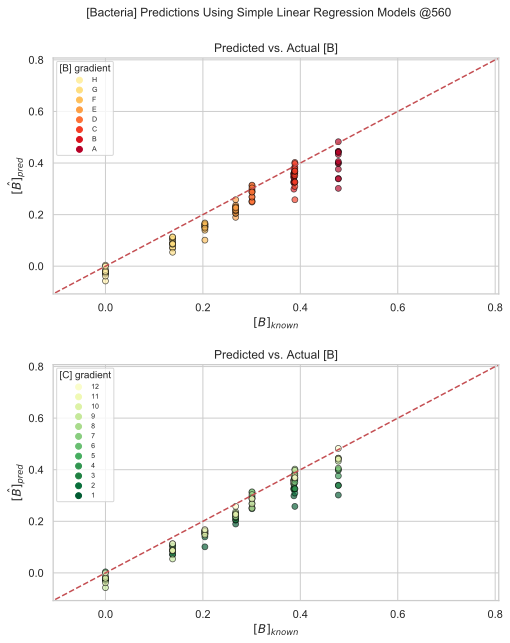

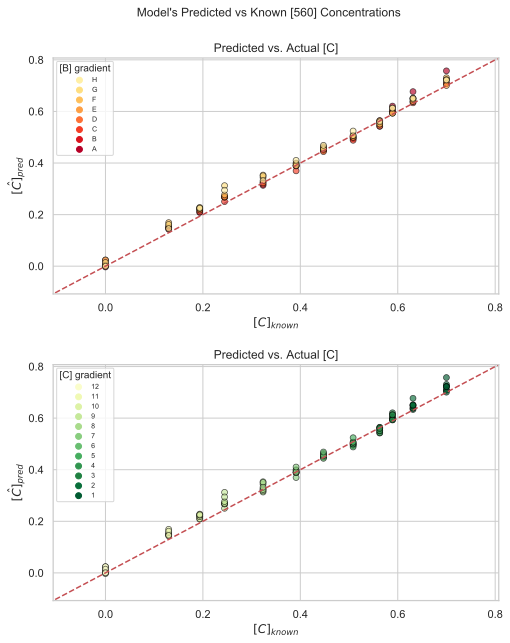

In [22]:
#a680_730_main_df.to_csv(save_to+'a680_730_pred_fractions.csv')
plot_pred_vs_known(a680_730_main_df, '560')

# Models for Screening Data

## A680 + A750

In [23]:
# This dictionary gets the coefficients which regress back to all wavelengths, however we are mostly
# interested in the 560nm wavelength, but are all available if neededed.

# apply these models to Tecan Data where the wavelengths measured are a600, a680, a750, this was the
# case for some of the the screening data
a680_a750 = get_coeff_dict_for_all_regressors(mdf, FIRST_REGRESSAND='A680', second_regressand='A750')

a680_a750_main_df = mdf.copy()
for reg in regressors:
    tmp = get_predictions(mdf, a680_a750, regressor=reg, first_regressand='A680', second_regressand='A750')
    a680_a750_main_df = pd.concat([a680_a750_main_df, tmp], axis=1)

In [24]:
#a680_a750_main_df.to_csv(save_to+'a680_a750_pred_fractions.csv')

## A600 + A750

In [25]:
# This dictionary gets the coefficients which regress back to all wavelengths, however we are mostly
# interested in the 560nm wavelength, but are all available if neededed.

# apply these models to Tecan Data where the wavelengths measured are a600, a680, a750, this was the
# case for some of the the screening data
a600_a750 = get_coeff_dict_for_all_regressors(mdf, FIRST_REGRESSAND='A600', second_regressand='A750')

a600_a750_main_df = mdf.copy()
for reg in regressors:
    tmp = get_predictions(mdf, a600_a750, regressor=reg, first_regressand='A600', second_regressand='A750')
    a600_a750_main_df = pd.concat([a600_a750_main_df, tmp], axis=1)
a600_a750_main_df.head()

,row,col,B_lbl,C_lbl,A600,A600_sdv,A680,A680_sdv,A720,A720_sdv,...,B_p710,C_p710,B_p720,C_p720,B_p730,C_p730,B_p740,C_p740,B_p750,C_p750
well,,,,,,,,,,,,,,,,,,,,,
A1,A,1,0.4,0.50,1.0938,0.0618,1.4928,0.0686,0.8732,0.0660,...,-0.468486,1.484272,-0.450100,1.389095,-0.428757,1.323989,-0.414746,1.288719,-0.398822,1.254855
A2,A,2,0.4,0.46,1.0292,0.0746,1.3929,0.0742,0.8300,0.0714,...,0.266473,0.607795,0.264419,0.570650,0.262829,0.545116,0.260438,0.531720,0.257783,0.519013
A3,A,3,0.4,0.42,0.9685,0.0768,1.2995,0.0818,0.7890,0.0758,...,1.065901,-0.337151,1.041661,-0.311703,1.015187,-0.294556,0.994988,-0.284354,0.972162,-0.274232
A4,A,4,0.4,0.38,0.9106,0.0732,1.2021,0.0791,0.7450,0.0742,...,1.343683,-0.697864,1.311548,-0.648632,1.276192,-0.615259,1.249681,-0.596111,1.219703,-0.577345
A5,A,5,0.4,0.34,0.8852,0.0785,1.1458,0.0879,0.7252,0.0804,...,1.355491,-0.733367,1.322903,-0.681856,1.287024,-0.646924,1.260166,-0.626932,1.229796,-0.607354


In [26]:
# #a600_a750_main_df.to_csv(save_to+'a600_a750_pred_fractions.csv')

# save_to = """/home/rdmtinez/Documents/B-IT MS Program/Masters Thesis/data_o/calibration/community_calibration/created_models/"""
# tdf = pd.DataFrame.from_dict(data=a600_a750,
#                              orient='index',
#                              columns=['kB600', 'kC600', 'kB750', 'kC750'])

# tdf.to_csv(save_to+'a600_a750_coefficients.csv')

# Special Model START

In [27]:
f='680' #'680'
s='540' #'540'
r='730' #'750'


a680_540 = get_coeff_dict_for_all_regressors(mdf, FIRST_REGRESSAND=f, second_regressand=s)

a680_540_main_df = mdf.copy()
for reg in [r]:
    tmp = get_predictions(mdf, a680_540, regressor=reg, first_regressand=f, second_regressand=s)
    a680_540_main_df = pd.concat([a680_540_main_df, tmp], axis=1)
a680_540_main_df.head()

save_to = """../data_o/calibration/community_calibration/created_models/"""

#a680_540_main_df.to_csv(pjoin(save_to, 'a680_540_main_df.csv'))

# tdf = pd.DataFrame.from_dict(data=a680_540,
#                              orient='index',
#                              columns=['kB680', 'kC680', 'kB540', 'kC540'])

# tdf.to_csv(save_to+'a680_a540_coefficients.csv')

,row,col,B_lbl,C_lbl,A600,A600_sdv,A680,A680_sdv,A720,A720_sdv,...,680,690,700,710,720,730,740,750,B_p730,C_p730
well,,,,,,,,,,,,,,,,,,,,,
A1,A,1,0.4,0.50,1.0938,0.0618,1.4928,0.0686,0.8732,0.0660,...,1.4652,1.2293,0.9723,0.8896,0.8541,0.8298,0.8166,0.8032,0.223756,0.593026
A2,A,2,0.4,0.46,1.0292,0.0746,1.3929,0.0742,0.8300,0.0714,...,1.3658,1.1698,0.9243,0.8486,0.8149,0.7924,0.7793,0.7660,0.244450,0.533610
A3,A,3,0.4,0.42,0.9685,0.0768,1.2995,0.0818,0.7890,0.0758,...,1.2734,1.0813,0.8680,0.7985,0.7672,0.7458,0.7334,0.7209,0.245450,0.488131
A4,A,4,0.4,0.38,0.9106,0.0732,1.2021,0.0791,0.7450,0.0742,...,1.1832,1.0131,0.8222,0.7584,0.7300,0.7094,0.6977,0.6858,0.262202,0.435298
A5,A,5,0.4,0.34,0.8852,0.0785,1.1458,0.0879,0.7252,0.0804,...,1.1227,0.9692,0.7939,0.7354,0.7079,0.6883,0.6763,0.6646,0.279066,0.396852


B_p730


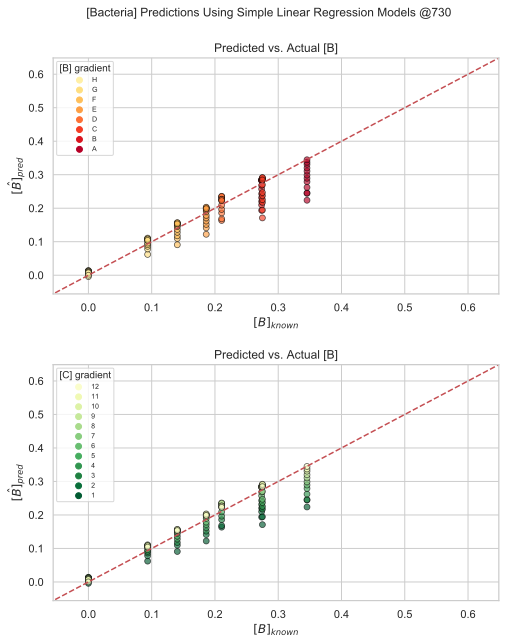

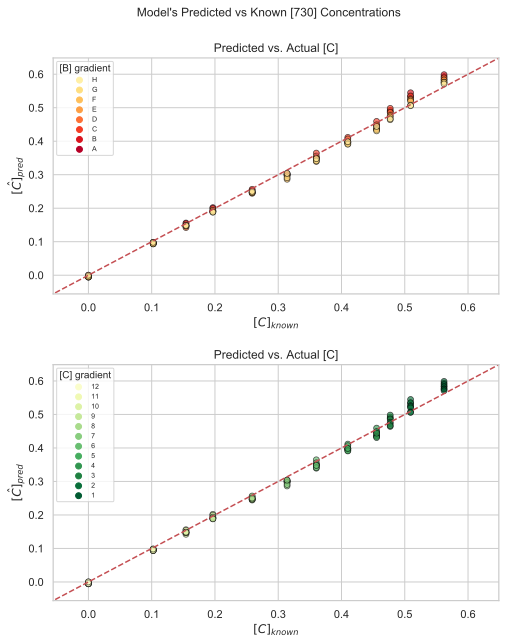

In [28]:
plot_pred_vs_known(a680_540_main_df, '730')

# Special Model END

# Save Models


In [29]:
save_to = """../data_o/calibration/community_calibration/created_models/"""

In [30]:
a680_a720['560']

[0.8341278366514564, 1.6388469217634034, 0.773945695811297, 0.826255292019431]

In [31]:
tdf = pd.DataFrame.from_dict(data=a680_a720,
                             orient='index',
                             columns=['kB680', 'kC680', 'kB720', 'kC720'])
#tdf.to_csv(save_to+'a680_a720_coefficients.csv')

In [32]:
tdf.head()

,kB680,kC680,kB720,kC720
A600,0.877526,1.617013,0.814493,0.816399
500,0.739568,1.003908,0.686166,0.505954
510,0.755922,1.152351,0.701362,0.580938
520,0.771260,1.338397,0.715587,0.674852
530,0.786517,1.473501,0.729752,0.743038


In [33]:
tdf = pd.DataFrame.from_dict(data=a680_730,
                             orient='index',
                             columns=['kB680', 'kC680', 'kB730', 'kC730'])

#tdf.to_csv(save_to+'a680_730_coefficients.csv')

In [34]:
tdf.head()

,kB680,kC680,kB730,kC730
A600,0.877526,1.617013,0.756929,0.796985
500,0.739568,1.003908,0.639104,0.495227
510,0.755922,1.152351,0.653205,0.568540
520,0.771260,1.338397,0.666553,0.660191
530,0.786517,1.473501,0.679764,0.726855


In [35]:
# tdf = pd.DataFrame.from_dict(data=a680_a750,
#                              orient='index',
#                              columns=['kB680', 'kC680', 'kB750', 'kC750'])

# tdf.to_csv(save_to+'a680_a750_coefficients.csv')

In [36]:
tdf.head()

,kB680,kC680,kB730,kC730
A600,0.877526,1.617013,0.756929,0.796985
500,0.739568,1.003908,0.639104,0.495227
510,0.755922,1.152351,0.653205,0.568540
520,0.771260,1.338397,0.666553,0.660191
530,0.786517,1.473501,0.679764,0.726855


# Apply NEW MODELs to old CALIBRATION DATA


In [37]:
# the predictions in this data_taodels use the A680 A750 derived coefficients
# therefore you should check the predicted values @ 560
# using the same wavelengths derived coeficients from the syncom data


# I don't expect them to be the same, but if we're looking for anything its
# the difference between the two models


# use single species calibration dataframe, remove the predictions and
# use the blank corrected values to make new predictions using the
# new models, compare the predictions to the know 560 values

path = """../data_o/calibration/single_species_calibration/predicted_fractions"""

# ss calib df with ss modeled predicted fractions
ss_calib_df = pd.read_csv(pjoin(path,'a680_a750_slr_predicted_fractions.csv'),
                 index_col=0)


In [38]:
#ss_calib_df.columns.values

In [39]:
# use just these columns to make predictions using the new models

keep_cols = ['row', 'col', 'B_lbl', 'C_lbl', 'F680', 'A680', 'A750', '320',
       '325', '330', '335', '340', '345', '350', '355', '360', '365',
       '370', '375', '380', '385', '390', '395', '400', '405', '410',
       '415', '420', '425', '430', '435', '440', '445', '450', '455',
       '460', '465', '470', '475', '480', '485', '490', '495', '500',
       '505', '510', '515', '520', '525', '530', '535', '540', '545',
       '550', '555', '560', '565', '570', '575', '580', '585', '590',
       '595', '600', '605', '610', '615', '620', '625', '630', '635',
       '640', '645', '650', '655', '660', '665', '670', '675', '680',
       '685', '690', '695', '700', '705', '710', '715', '720', '725',
       '730', '735', '740', '745', '750', '755', '760', '765', '770',
       '775', '780', '785', '790', '795', '800']

# old calib data withouth predicted fractions to get new one
ss_calib_df2 = ss_calib_df[keep_cols].copy()

# get predictions onto new DF using ss_calibration use these predictions
# to validate your new models and the correction functions, what is
# expected? I expect that the SC derived models are of better caliber than
# the SS models thus are much better at capturing the signal and imparting 
# beer-law as expected. However, the signals are convoluted by specific and
# dynamic factors that can be resolved post-prediction. Therefore once 
# these predictions have been made on this old data and the correction
# functions are also applied on those predictions, then the corrected values
# should be close to the '560' measurements at [C] @rowH and [B] @col12

tmp = get_predictions(df=ss_calib_df2, coef_dict=a680_540 , regressor='750',
                       first_regressand='A680', second_regressand='540')

# sc on ss predicted fractions to visualize using visualize
sc_on_ss_preds_df = pd.concat([ss_calib_df2, tmp], axis=1)

# save predictions
path = '/home/rdmtinez/Documents/B-IT MS Program/Masters Thesis/data_o/\
calibration/validation'
#sc_on_ss_preds_df.to_csv(pjoin(path,'sc_models_on_ss_data_pred_560_a680_a720.csv'))

In [40]:
# save the measured wavelengths and their blank-corrected values

# path = '/home/rdmtinez/Documents/B-IT MS Program/Masters Thesis/data_o/\
# calibration/single_species_calibration/parsed_data'
# old_calib_df.to_csv(pjoin(path,'blank_corrected_sing_strain_calibration_df.csv'))

In [41]:
# old modeled data to compare agasinst new modeled data
odf = ss_calib_df[['row', 'col', 'A680','720', 'A750', '560', 'B_p750', 'C_p750']]
odf = odf.rename({'B_p750':'oB_p560_750', 'C_p750':'oC_p560_750'},axis=1)

# SynCom derived models applied to single strain data
new_n_old_preds = pd.concat([odf, tmp], axis=1)

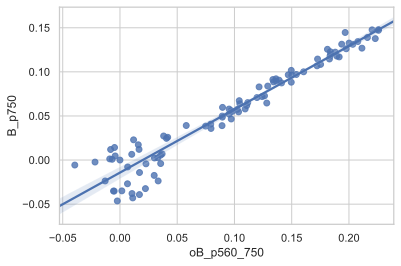

In [42]:
# comparing [560] using regression of 720 pred 750
sns.regplot(data=new_n_old_preds, x='oB_p560_750', y='B_p750')

# The models were built using different set-ups, in one we have a monoculture
# of a bacterial strain and in another we have a subset of our bacteria
# collection. We did not expect to much variability between the models
# themselves, but indeed this is what we did get. Therefore, we know that
# there should be variability between the predictions themselves.
# When plot the different model's predictions against each other we 
# expect them to be correlated against each other, but that they should
# not hug the 1:1 line 

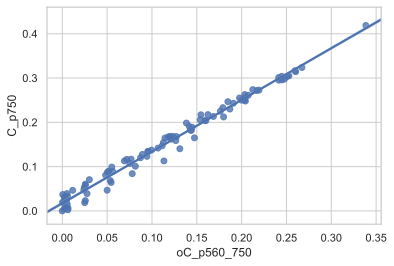

In [43]:
# Predictions for C should be highly correlated as these coefficients are very
# distinct
sns.regplot(data=new_n_old_preds, x='oC_p560_750', y='C_p750')

'sc_model_on_ss'

B_p750


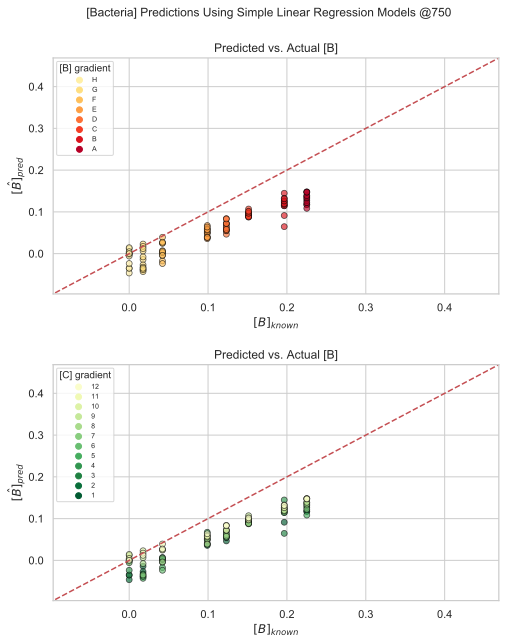

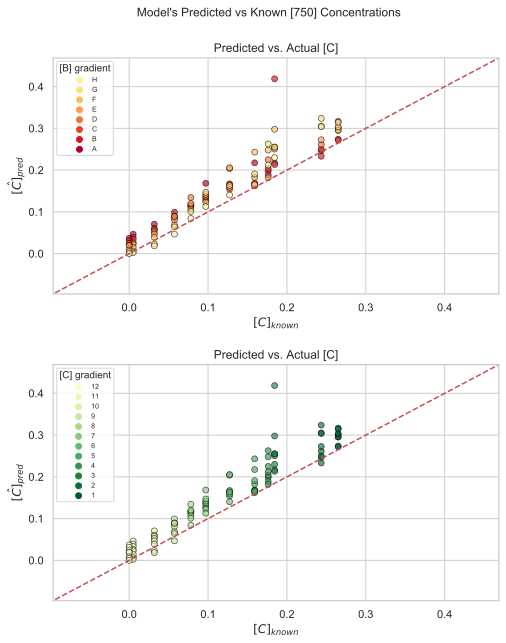

In [44]:
'sc_model_on_ss'
plot_pred_vs_known(sc_on_ss_preds_df, '750')

'ss_modeled'

B_p560


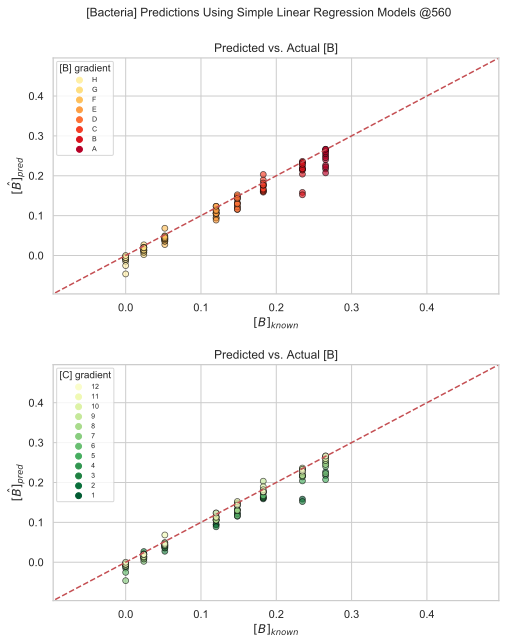

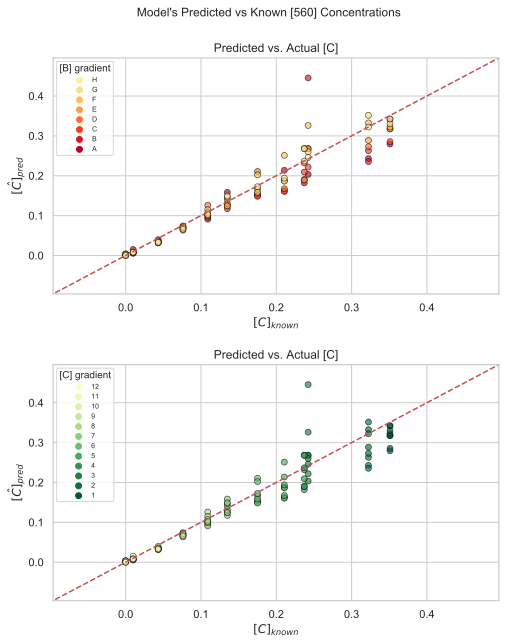

In [45]:
'ss_modeled'
plot_pred_vs_known(ss_calib_df, '560')

In [46]:
def get_96position(tdf, column='440'):
    """Returns the values of wanted column (lamda) as a DataFrame
    resembling its 96well plate layout. Facilitates comparison"""
    ninsix = pd.DataFrame()
    for l in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']:
        c = tdf[tdf.index.str.contains(l)][column].values
        ninsix[l] = c
    ninsix = ninsix.transpose()
    ninsix.columns = ninsix.columns+1

    return ninsix.round(6)

# PREDICTED 560 fractions Fractions
wc='560'

pB = get_96position(sc_on_ss_preds_df, 'B_p'+wc)
pC = get_96position(sc_on_ss_preds_df, 'C_p'+wc)

# 'KNOWN Concentrations as Measured by 560 at row H and col 12'
sc_on_ss_preds_df = set_B_and_C(sc_on_ss_preds_df, wc)

B = get_96position(sc_on_ss_preds_df, 'B')
C = get_96position(sc_on_ss_preds_df, 'C')


cm = [sns.light_palette("brown", as_cmap=True),
      sns.light_palette("green", as_cmap=True), 
      sns.light_palette("purple", as_cmap=True)]

"Predicted Values @ 560 vs. Expcted 'Known' Concentration @ 560"
'pB'
pB.style.background_gradient(cmap=cm[0], axis=None)
'B_known'
B.style.background_gradient(cmap=cm[0], axis=None)


'pC'
pC.style.background_gradient(cmap=cm[1], axis=None)
'C_known'
C.style.background_gradient(cmap=cm[1], axis=None)

from sklearn.linear_model import LinearRegression

def quick_scrip():
    
    """Here we're visualizing the predicted values of C (pC) at each well in a column by
    column basis with respect to the known concetration of B. The lines should all be
    flat if the predictions were perfect, but there is a bit of signal addition given by 
    the bacteria. The addition to the signal is dependant on the concentration of B"""
    
    fig, ax = plt.subplots(figsize=(8,5))
    coefs = []
    yints = []
    c_at_cols = [i for i in C.loc['H'].values]
    for i in range(1,13):

        # create a regression object for pC v [B] (B known) and extract coefficients
        regr = LinearRegression()
        k = regr.fit(y=pC[i].values.reshape(-1,1), X=B[12].values.reshape(-1,1))
                    
        coefs.append(k.coef_[0][0])

        sns.regplot(y=pC[i], x=B[12], order=1)
        #sns.regplot(y=pC[i]-pC[i]['H'], x=B[12], order=1)
        

    ax.set_ylabel('pC')
    ax.set_xlabel('B')


    ax.set_ylim(-0.2, .6)
    ax.set_xlim(-0.4, .8)
    ax.legend(c_at_cols, 
              title='C_known @ Col')
    plt.show()
    print('coefs', coefs)
    print()
    print('c_at_cols', c_at_cols)

    
def quick_scrip2():
    
    """Here we're visualizing the predicted values of B (pB) at each well in a row by
    row basis with respect to the known concetration of C. The lines should all be
    flat if the predictions were perfect, but there is a bit of signal addition given by 
    the bacteria. The addition to the signal is dependant on the concentration of B"""
    
    fig, ax = plt.subplots(figsize=(8,5))
    coefs = []
    b_max = []
    b_at_cols = []
    for i in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']:
        
        b_at_cols.append(B.loc[i][12])
        # append max value of each column
        b_max.append(max(pB.loc[i]))
        # create a regression plot for pB v [C] (C known)
        sns.regplot(y=pB.loc[i], x=C.loc['H'], order=2, truncate=False)
        # check for any patterns --- none exist, but we do see the same
        # effecft of chalmy adding signal to B when [B] < 0.05
        
        # average these regresssion coefficient to a global one
        # and use it as a correction factor for pB
        regr = LinearRegression()
        k = regr.fit(y=pB.loc[i].values.reshape(-1,1), X=C.loc['H'].values.reshape(-1,1))
                    
        coefs.append(k.coef_[0][0])

    ax.set_ylabel('pB')
    ax.set_xlabel('C')


    ax.set_ylim(-0.2, .4)
    ax.set_xlim(-0.3, .8)
    ax.legend(b_at_cols, 
              title='B_known @ Row')
    plt.show()
    print('coefs', coefs)
    print('b_known_at_cols, b_max_at_col', [i for i in zip(b_at_cols, b_max)])

quick_scrip()
quick_scrip2()

# Visualizaion

In [47]:
def quickplot():
    
    models_dfs = [a680_a720_main_df, a680_730_main_df,
                  a680_a750_main_df, a600_a750_main_df,
                 a680_540_main_df, a680]
    strs = ['a680_a720_main_df', 'a680_730_main_df',
            'a680_a750_main_df', 'a600_a750_main_df',
            'a680_540_main_df']

    i = 0
    for df in models_dfs:

        print(strs[i])
        
        if i <4:
            p_sum = df['B_p560'] + df['C_p560']
        else:
            p_sum = df['B_p750'] + df['C_p750']
            
        fig, ax= plt.subplots(figsize=(9,5))

        x = np.linspace(-0.02,1.1,20)
        y = x
        y2 = x + .0233
        ax.plot(x, y, '--r', x, y2, '--b')
        # sum of predictions vs. known
        if i <4:
            sns.scatterplot(x=df['560'],y=p_sum, ax=ax, color='blue', alpha=0.6, legend=False) 
        else:
            sns.scatterplot(x=df['750'],y=p_sum, ax=ax, color='blue', alpha=0.6, legend=False) 
            

        ax.set_title('Prediction Sums V. Empircal Measurements')
        ax.set_ylabel('Predicted Component Sums')
        ax.set_xlabel("Empirical Measurement @ $A_{560}$")
        
        if i <4:
            plot_pred_vs_known(df, '560')
        else:
            plot_pred_vs_known(df, '750')
            
        i+=1        



In [48]:
#a600_a750_main_df.head()
quickplot()

NameError: name 'a680' is not defined

# Analysis

Note: The known concentrations are those made at the H'th row and 12th column. Thus in the above graphs what we're seeing for Chlamy can be interpreted as follows... at any given well the measured '560' signal matches the corresponding signal at 

In [ ]:
relcols=['A680', 'A720', '560', 'B_p560', 'C_p560']
tdf = a680_a720_main_df[relcols].copy()
tdf.head()

In [ ]:
tdf['sum'] = tdf['B_p560'] + tdf['C_p560']
tdf['rat'] = tdf['B_p560'] / tdf['C_p560']



tdf['6/7'] = tdf['A680'] / tdf['A720']
tdf['7/6'] = tdf['A720'] / tdf['A680']

tdf['l(6/7)'] = np.log10(tdf['A680'] / tdf['A720'])
tdf['l(7/6)'] = np.log10(tdf['A720'] / tdf['A680'])


tdf.head()

In [ ]:
bdx = ['A12', 'B12', 'C12','D12',
         'E12', 'F12', 'G12', 'H12']

cdx = ['H1', 'H2', 'H3', 'H4',
      'H5', 'H6', 'H7', 'H8',
       'H9', 'H10', 'H11', 'H12']

In [ ]:
tdf.loc[bdx]

# Predicted vs A680/A720

In [ ]:
sns.regplot(data=tdf.loc[bdx], y='B_p560', x='6/7')


In [ ]:
sns.regplot(data=tdf.loc[cdx], y='C_p560', x='6/7')

# Predicted vs log(A680/A720)

In [ ]:
sns.regplot(data=tdf.loc[bdx], y='B_p560', x='l(6/7)')

In [ ]:
sns.regplot(data=tdf.loc[cdx], y='C_p560', x='l(6/7)')

In [ ]:
tdf.head()

# Sums of Predictions vs Known Per Model

In [ ]:
ns = [['skB1','skC1','skB2','skC2']]
vals = np.array([1, 2, 3, 5]).reshape(1,-1)

pd.DataFrame(data=vals, columns=ns)